--2021-05-25 14:42:08--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.7.240, 172.217.8.16, 172.217.13.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.7.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5057493 (4.8M) [application/octet-stream]
Saving to: ‘/tmp/bbc-text.csv’

/tmp/bbc-text.csv   100%[===================>]   4.82M  --.-KB/s    in 0.03s   

2021-05-25 14:42:08 (173 MB/s) - ‘/tmp/bbc-text.csv’ saved [5057493/5057493]

153
2225
2225
tv future hands viewers home theatre systems  plasma high-definition tvs  digital video recorders moving living room  way people watch tv will radically different five years  time.  according expert panel gathered annual consumer electronics show las vegas discuss new technologies will impact one favourite pastimes. us leading trend  programmes content will delivered viewers via home netwo

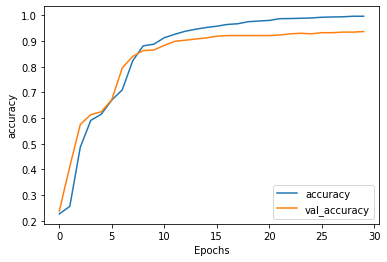

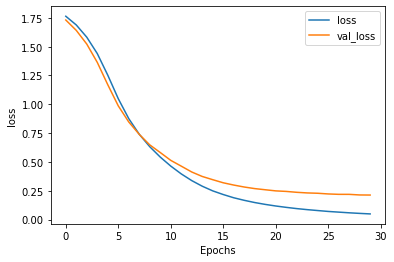

In [ ]:
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv \
    -O /tmp/bbc-text.csv


vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_portion = .8


sentences = []
labels = []
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]
print(len(stopwords))

with open("/tmp/bbc-text.csv", 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        labels.append(row[0])
        sentence = row[1]
        for word in stopwords:
            token = " " + word + " "
            sentence = sentence.replace(token, " ")
        sentences.append(sentence)

print(len(labels))
print(len(sentences))
print(sentences[0])

train_size = int(len(sentences) * training_portion)

train_sentences = sentences[:train_size]
train_labels = labels[:train_size]

validation_sentences = sentences[train_size:]
validation_labels = labels[train_size:]

print(train_size)
print(len(train_sentences))
print(len(train_labels))
print(len(validation_sentences))
print(len(validation_labels))

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)

print(len(train_sequences[0]))
print(len(train_padded[0]))

print(len(train_sequences[1]))
print(len(train_padded[1]))

print(len(train_sequences[10]))
print(len(train_padded[10]))

validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
validation_padded = pad_sequences(validation_sequences, padding=padding_type, maxlen=max_length)

print(len(validation_sequences))
print(validation_padded.shape)


label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

print(training_label_seq[0])
print(training_label_seq[1])
print(training_label_seq[2])
print(training_label_seq.shape)

print(validation_label_seq[0])
print(validation_label_seq[1])
print(validation_label_seq[2])
print(validation_label_seq.shape)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

num_epochs = 30
history = model.fit(train_padded, training_label_seq, epochs=num_epochs, validation_data=(validation_padded, validation_label_seq), verbose=2)


import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")


reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

e = model.layers[0]
weights = e.get_weights()[0]

import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()